In [188]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from mlxtend.classifier import OneRClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

In [96]:
x_train = pd.read_csv('/kaggle/input/ppcu-data-mining-and-machine-learning-2022/X_train.csv')
y_train = pd.read_csv('/kaggle/input/ppcu-data-mining-and-machine-learning-2022/y_train.csv')

# Data preprocessing

In [97]:
x_train.drop(['Id'], inplace=True, axis=1); #drop ID column
y_train.drop(['Id'], inplace=True, axis=1); #drop ID column
x_train = x_train[x_train.columns[x_train.isnull().mean() < 0.75]] #drop columns with more than 75% missing 
columns_to_keep = x_train.columns[x_train.isnull().mean() < 0.75]

column_to_remove = ''
for i in x_train:
    if x_train[i].std() == 0:
        #x_train = x_train.drop([i],axis=1) #dropping this column degrades performance?!
        print(i)
        column_to_remove = i

cd_000


In [98]:
x_train.isnull().sum().sum() # still many null values left
# but we should only impute them after splitting the data 
x_train.shape

(39900, 164)

In [99]:
train, test, y_train, y_test = train_test_split(x_train, y_train,test_size=0.3, random_state=42)
print(train.shape)
print(y_train.shape)
print(test.shape)
print(y_test.shape)

train = train.fillna(train.median()) #TODO do the same on the real prediction test set as well!!!
test = test.fillna(train.median())

(27930, 164)
(27930, 1)
(11970, 164)
(11970, 1)


In [100]:
X_test = pd.read_csv('/kaggle/input/ppcu-data-mining-and-machine-learning-2022/X_test.csv')
X_test.shape

X_test = X_test.fillna(x_train.median()) # do the same on the real prediction test set as well here!!!
print(X_test.shape)
X_test = X_test[columns_to_keep]
print(X_test.shape)
#X_test = X_test.drop([column_to_remove],axis=1) 
#print(X_test.shape)

(17100, 171)
(17100, 164)


# Predictions

In [101]:
def save_prediction(y_pred, filename):
    f = open(filename,'w')
    f.write("Id,Predicted\n")
    for i,val in enumerate(y_pred):
        f.write("{},{}\n".format(i,val))
    f.flush()
    f.close()

In [102]:
def smote_oversample(x,y):
    oversample = SMOTE()
    train_os, y_train_os = oversample.fit_resample(x,y)
    return train_os, y_train_os
    
def random_oversample(x,y):
    oversample = RandomOverSampler()
    train_os, y_train_os = oversample.fit_resample(x,y)
    return train_os, y_train_os
    
def random_undersample(x,y):
    undersample = RandomUnderSampler()
    train_os, y_train_os = undersample.fit_resample(x,y)
    return train_os, y_train_os

In [103]:
def scale_data():
    scaler = StandardScaler()
    train_std = scaler.fit_transform(train)
    test_std = scaler.transform(test)
    X_test_std = scaler.transform(X_test)
    return train_std, test_std, X_test_std

In [111]:
def cv_search_prarmeters(param, estimator,x_train,y_train):
    search = RandomizedSearchCV(estimator, param, cv=10,
                            scoring='recall',
                            random_state=42).fit(x_train, y_train)
    print(search.best_estimator_)
    print(f"10-CV Best Parameters = {search.best_params_}")
    print(f"10-CV Best Score = {search.best_score_}")
    return search.best_estimator_

In [104]:
#1R

#runs for too long, couldn't get it to work 
#oneR = OneRClassifier()
#oneR.fit(np.array(train)[:15000,:], np.array(y_train)[:15000,:].ravel())
#pr = oneR.predict(np.array(test))
#f3 = fbeta_score(y_test, pr, average='macro', beta=3)

DECISION TREE

In [105]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(train,y_train)

pred = clf.predict(test)
f3 = fbeta_score(y_test, pred, beta=3, average='macro')
print("F3 score: ", f3)

F3 score:  0.8469251876754869


In [112]:
parameters = {'max_depth': [None,3,5,7,8,9,15,25,30,35,40,45],
              'min_samples_split': [2,3,5],
              'min_samples_leaf':[1,2,4,5]}
estimator =  DecisionTreeClassifier(random_state = 42)
best_dtc_estimator = cv_search_prarmeters(parameters, estimator,
                                          train,y_train)

pr = best_dtc_estimator.predict(test)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

DecisionTreeClassifier(max_depth=45, random_state=42)
10-CV Best Parameters = {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 45}
10-CV Best Score = 0.6204705882352941
0.8469251876754869


Logistic Regression

In [109]:
lr = LogisticRegression(penalty='l2', solver='newton-cg', max_iter=400)
lr.fit(train, np.ravel(y_train))

pr = lr.predict(test)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

0.8386878996189712


/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


weighted logistic regression

In [117]:
weights = {0:1.0, 1:50}
model = LogisticRegression(solver='lbfgs', class_weight=weights, max_iter =400)
model.fit(train, np.ravel(y_train))

pr = model.predict(test)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

0.896898236149501


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [120]:
train_os, y_train_os = smote_oversample(train, y_train)

pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter = 400))
pipeline.fit(train_os, np.ravel(y_train_os))

pr = pipeline.predict(test)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3) 

#y_pred = pipeline.predict(X_test)
#save_prediction(y_pred,"a.csv")

0.9019464084846538


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


SVM

In [118]:
svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm.fit(train, np.ravel(y_train))

pr = svm.predict(test)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

0.6217220431932161


SMOTE + SVM

In [170]:
counter = Counter(y_train["Expected"])
print(counter) #before upsampling
oversample = SMOTE()
train_os, y_train_os = oversample.fit_resample(train, y_train)
counter =  Counter(y_train_os["Expected"])
print("After SMOTE sampling, the frequency of class variable: ", counter)

Counter({0: 27424, 1: 506})
After SMOTE sampling, the frequency of class variable:  Counter({0: 27424, 1: 27424})


In [171]:
svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm.fit(train_os, np.ravel(y_train_os))

pr = svm.predict(test)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

0.8662326575625242


random undersampling + SVM

In [172]:
counter = Counter(y_train["Expected"])
print(counter) #before upsampling
rus = RandomUnderSampler(random_state=0)
train_os, y_train_os = rus.fit_resample(train, y_train)
counter =  Counter(y_train_os["Expected"])
print("After undersampling, the frequency of class variable: ", counter)

svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm.fit(train_os, np.ravel(y_train_os))

pr = svm.predict(test)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

Counter({0: 27424, 1: 506})
After undersampling, the frequency of class variable:  Counter({0: 506, 1: 506})
0.8552137369574508


random oversampling + SVM

In [173]:
ros = RandomOverSampler(random_state=0)
train_os, y_train_os = ros.fit_resample(train, y_train)

svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm.fit(train_os, np.ravel(y_train_os))

pr = svm.predict(test)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

0.8701033430576847


Random Forest

In [174]:
rfc = RandomForestClassifier(max_depth=2, random_state=42)
rfc.fit(train, np.ravel(y_train))

pr = rfc.predict(test)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

0.6098395137627315


Random Forest + SMOTE

In [175]:
oversample = SMOTE()
train_os, y_train_os = oversample.fit_resample(train, y_train)

rfc = RandomForestClassifier(max_depth=2, random_state=42)
rfc.fit(train_os, np.ravel(y_train_os))

pr = rfc.predict(test)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

0.8436144285106268


Random Forest + random undersampling

In [176]:
rus = RandomUnderSampler(random_state=0)
train_os, y_train_os = rus.fit_resample(train, y_train)

rfc = RandomForestClassifier(max_depth=2, random_state=42)
rfc.fit(train_os, np.ravel(y_train_os))

pr = rfc.predict(test)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

0.8334974146491798


Naive Bayes

In [177]:
nb = GaussianNB()
nb.fit(train, np.ravel(y_train))

pr = nb.predict(test)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

0.868579675559377


Naive Bayes + smote

In [178]:
oversample = SMOTE()
train_os, y_train_os = oversample.fit_resample(train, y_train)

nb = GaussianNB()
nb.fit(train_os, np.ravel(y_train_os))

pr = nb.predict(test)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

0.8761329725369859


Naive Bayes + random undersampling

In [192]:
rus = RandomUnderSampler()
train_os, y_train_os = rus.fit_resample(train, y_train)

nb = GaussianNB()
nb.fit(train_os, np.ravel(y_train_os))

pr = nb.predict(test)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

0.874016433442064


KNN, n=3

In [131]:
knc = KNeighborsClassifier(n_neighbors=3)
knc.fit(train, np.ravel(y_train))

pr = knc.predict(test)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

0.6940810402982109


KNN hyperparameter search

In [133]:
sc = StandardScaler()
train_std = sc.fit_transform(train)
test_std = sc.transform(test)

oversample = SMOTE()
train_os, y_train_os = oversample.fit_resample(train_std, y_train)

# KNN Tune Parameter
parameters = {'n_neighbors': [5,7,11,13]}
estimator =  KNeighborsClassifier()

best_knn_estimator = cv_search_prarmeters(parameters, estimator,
                                          train_os,np.ravel(y_train_os))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


KNeighborsClassifier()
10-CV Best Parameters = {'n_neighbors': 5}
10-CV Best Score = 0.9998906041051914


KNN tuned version

In [127]:
sc = StandardScaler()
train_std = sc.fit_transform(train)
test_std = sc.transform(test)

oversample = SMOTE()
train_os, y_train_os = oversample.fit_resample(train_std, y_train)

knc = KNeighborsClassifier(n_neighbors=5)
knc.fit(train_os, np.ravel(y_train_os))

pr = knc.predict(test_std)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

0.8934844917405267


K-means

In [182]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(train)

pr = kmeans.predict(test)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

0.4271537571108779


K-means scaled

In [181]:
sc = StandardScaler()
train_std = sc.fit_transform(train)
test_std = sc.transform(test)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(train_std)

pr = kmeans.predict(test_std)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

0.8297353269772798


RidgeClassifier

In [180]:
rc = RidgeClassifier()
rc.fit(train, np.ravel(y_train))

pr = rc.predict(test)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

0.7528309030606952


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.89034e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


XGBClassifier

In [150]:
x = xgb.XGBClassifier(max_depth=5, n_estimators = 100, random_state = 42) 
x.fit(train_os, y_train_os)
y_pred = x.predict(test)

f3 = fbeta_score(y_test, y_pred, average='macro', beta=3)
print(f3)

0.9078353148069881


AdaBoost

In [179]:
train_os, y_train_os = smote_oversample(train,y_train)

ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(train_os, np.ravel(y_train_os))
        
pr = ada.predict(test)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

0.9003599837730069


# Tuning

XGBoost hyperparameter search 

In [143]:
train_os, y_train_os = smote_oversample(train,y_train)

# model
clf = xgb.XGBClassifier(n_jobs=-1, random_state = 42)

# parameters
params = {'n_estimators':[5, 50,100, 120, 150, 180],
         'max_depth':[5,10,15],
         'subsample':  [0.6, 0.7, 0.8, 0.9, 1]}
#scorer
my_scorer = make_scorer(fbeta_score, beta=3)

# random search
xgb_randomsearch = RandomizedSearchCV(clf, param_distributions=params,
                                    n_jobs=-1, verbose=2,
                                    scoring=my_scorer, n_iter=15,
                                    cv=3, random_state=42)
xgb_randomsearch.fit(train_os, y_train_os)
print(xgb_randomsearch.best_params_)
print(xgb_randomsearch.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
{'subsample': 0.6, 'n_estimators': 180, 'max_depth': 10}
0.9981919001090117


In [151]:
y_pred = xgb_randomsearch.predict(X_test)
save_prediction(y_pred,"xgb_hyp_tuned.csv")

clustering + regression

In [183]:
#Let's try to combine regression and clustering
# and add the clusters as features (column)
kmeans = KMeans(init="random", n_clusters=2,n_init=10,max_iter=300,random_state=42)
kmeans.fit(train_std)
train_cluster = kmeans.predict(train_std)

#append cluster
train_new =  np.append(train, train_cluster[:,None], axis=1)

#regression
weights = {0:1.0, 1:50}
model = LogisticRegression(solver='lbfgs', class_weight=weights)
model.fit(train_new, np.ravel(y_train))

#test set
predicted_clusters = kmeans.predict(test_std)
test_new =  np.append(test, predicted_clusters[:,None], axis=1)
pr = model.predict(test_new)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

#predicted_clusters = kmeans.predict(X_test)
#X_test_new =  np.append(X_test, predicted_clusters[:,None], axis=1)
#y_pred = model.predict(X_test_new)
#save_prediction(y_pred,"regression_and_clustering.csv") 

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8814644951560392


PCA

In [155]:
train_std, test_std, X_test_std = scale_data()

pca = PCA() 
clf = SVC(gamma="auto") 
pipe = Pipeline([("pca",pca), ("clf",clf)]) 

parameters = {'pca__n_components': range(5,20),'clf__C': np.arange(0.2,0.5,0.05)}

search = GridSearchCV(pipe, parameters, scoring=my_scorer,
                      cv=3, verbose=3) 
search.fit(train_std, np.ravel(y_train))

#print("Best parameters (CV score: {:0.3f}):".format(search.best_score_))
print(search.best_params_)

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV 1/3] END ...clf__C=0.2, pca__n_components=5;, score=0.000 total time=   2.2s
[CV 2/3] END ...clf__C=0.2, pca__n_components=5;, score=0.000 total time=   2.4s
[CV 3/3] END ...clf__C=0.2, pca__n_components=5;, score=0.000 total time=   2.3s
[CV 1/3] END ...clf__C=0.2, pca__n_components=6;, score=0.000 total time=   2.3s
[CV 2/3] END ...clf__C=0.2, pca__n_components=6;, score=0.000 total time=   2.4s
[CV 3/3] END ...clf__C=0.2, pca__n_components=6;, score=0.000 total time=   2.2s
[CV 1/3] END ...clf__C=0.2, pca__n_components=7;, score=0.000 total time=   2.3s
[CV 2/3] END ...clf__C=0.2, pca__n_components=7;, score=0.000 total time=   2.5s
[CV 3/3] END ...clf__C=0.2, pca__n_components=7;, score=0.000 total time=   2.3s
[CV 1/3] END ...clf__C=0.2, pca__n_components=8;, score=0.000 total time=   2.3s
[CV 2/3] END ...clf__C=0.2, pca__n_components=8;, score=0.000 total time=   2.5s
[CV 3/3] END ...clf__C=0.2, pca__n_components=8

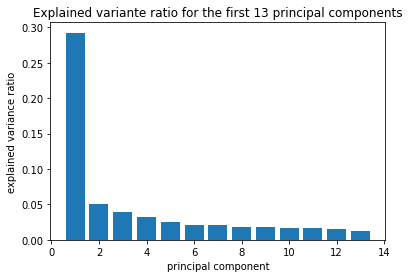

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.49908284928156527


In [166]:
train_std, test_std, X_test_std = scale_data()
clf = SVC(gamma="auto", C=0.4) 
pca = PCA(n_components=13) 
train_pca = pca.fit_transform(train_std)
test_pca = pca.transform(test_std)
X_test_pca = pca.transform(X_test_std)

plt.bar(np.arange(1,14), pca.explained_variance_ratio_)
plt.xlabel("principal component")
plt.ylabel("explained variance ratio")
plt.title("Explained variante ratio for the first 13 principal components")
plt.show()

clf.fit(train_pca,y_train)
pr = clf.predict(test_pca)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

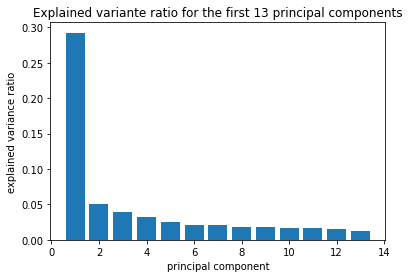

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5016577816845332


In [195]:
train_std, test_std, X_test_std = scale_data()
clf = SVC(gamma="auto", C=0.4) 
pca = PCA(n_components=13) 
train_pca = pca.fit_transform(train_std)
test_pca = pca.transform(test_std)
X_test_pca = pca.transform(X_test_std)

plt.bar(np.arange(1,14), pca.explained_variance_ratio_)
plt.xlabel("principal component")
plt.ylabel("explained variance ratio")
plt.title("Explained variante ratio for the first 13 principal components")
plt.show()

clf.fit(train_pca,y_train)
pr = clf.predict(test_pca)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

In [169]:
sc = StandardScaler()
train_std = sc.fit_transform(train)
oversample = SMOTE()
train_os_pca, y_train_os = oversample.fit_resample(train_pca, y_train)

clf = xgb.XGBClassifier(max_depth=10, n_estimators = 180,
                         subsample = 0.6, random_state=42) 
clf.fit(train_os_pca,np.ravel(y_train_os))

pr = clf.predict(test_pca)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

#X_test_scaled = sc.transform(X_test)
#X_test_pca = pca.transform(X_test_scaled)
#y_pred = clf.predict(X_test_pca)
#save_prediction(y_pred,"pca_xgb_os.csv") 

0.8944805658625615


Voting

In [185]:
train_os, y_train_os = smote_oversample(train,y_train)

clf1 = xgb.XGBClassifier(max_depth=10, n_estimators = 180,
                         subsample = 0.6, random_state=42) 
clf2 = LogisticRegression(penalty='l2', solver='newton-cg', max_iter=400)
clf3 = GaussianNB()


eclf1 = VotingClassifier(estimators=[('xgb', clf1), ('lr', clf2), ('gnb', clf3)], voting='hard')
eclf1 = eclf1.fit(train_os,np.ravel(y_train_os))

pr = eclf1.predict(test)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

#y_pred = eclf1.predict(X_test)
#save_prediction(y_pred,"new_vot.csv") 

/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


0.9129742163447763


Bagging

In [190]:
#this takes forever to run 
train_os, y_train_os = smote_oversample(train,y_train)
clf = BaggingClassifier(LogisticRegression(penalty='l2', solver='newton-cg', max_iter=400),
                        n_estimators=10, random_state=42).fit(train_os, y_train_os)
pr = clf.predict(test)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-

0.8943206217566715


In [193]:
train_os, y_train_os = smote_oversample(train,y_train)
clf = xgb.XGBClassifier(max_depth=10, n_estimators = 180,
                         subsample = 0.6, random_state=42).fit(train_os,y_train_os)
 
clf = BaggingClassifier(clf,n_estimators=10, random_state=42).fit(train_os, y_train_os)
pr = clf.predict(test)
f3 = fbeta_score(y_test, pr, average='macro', beta=3)
print(f3)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9226970075357663
